# Regulome Explorer  Kruskal-Wallis test for numerical and categorical data

In this notebook we describe how Regulome Explorer uses Kruskal-Wallis test to compute the significance of associations between a numerical feature (Gene expression, Somatic copy number, etc.) and a categorical feature. Details of the Kruskal-Wallist test can be found in the following link: https://en.wikipedia.org/wiki/Kruskal%E2%80%93Wallis_one-way_analysis_of_variance 

To describe the implementation of the test using BigQuery, we will use Gene expresion data of a user defined gene and a user defined clinical feature. This data is read from a BigQuery table in the pancancer-atlas dataset.

## Authenticate with Google  (IMPORTANT)
The first step is to authorize access to BigQuery and the Google Cloud. For more information see ['Quick Start Guide to ISB-CGC'](https://isb-cancer-genomics-cloud.readthedocs.io/en/latest/sections/HowToGetStartedonISB-CGC.html) and alternative authentication methods can be found [here](https://googleapis.github.io/google-cloud-python/latest/core/auth.html).

#### Import Python libraries

In [105]:
from google.cloud import bigquery
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import mstats
import seaborn as sns
import re_module.bq_functions as regulome

## User defined Parameters
The parameters for this experiment are the cancer type, the name of gene for which gene expression data will be obtained, and the clinical feature name. Categorical groups with number of samples smaller than 'MinSampleSize' will be ignored in the test.   

In [116]:
cancer_type = 'BRCA'
gene_name = 'PGR'
clinical_feature = 'breast_carcinoma_progesterone_receptor_status'
MinSampleSize = 10

bqclient = bigquery.Client()

## Data from BigQuery tables

**Gene expression data from the BigQuery:** The following query string retrieves the gene expression data of the user specified gene ('gene_name') from the 'Filtered.EBpp_AdjustPANCAN_IlluminaHiSeq_RNASeqV2_genExp_filtered' table available in pancancer-atlas dataset.

In [117]:
query_table1 = """table1 AS (
SELECT  symbol, data, ParticipantBarcode
FROM ( 
   SELECT 
         Symbol AS symbol, AVG( LOG10( normalized_count + 1 )) AS data, ParticipantBarcode
   FROM  `pancancer-atlas.Filtered.EBpp_AdjustPANCAN_IlluminaHiSeq_RNASeqV2_genExp_filtered` 
   WHERE Study = '{0}' AND Symbol ='{1}' AND normalized_count IS NOT NULL
   GROUP BY 
         ParticipantBarcode, symbol
   )
)
""".format(cancer_type, gene_name )

**Clinical data from the BigQuery:** The following string query will retrieve clinical data fromthe 'pancancer-atlas.Filtered.clinical_PANCAN_patient_with_followup_filtered' table available in pancancer-atlas dataset. It is worth noting that some of the values of the clinical feature may be 'indetermined' or 'not-evaluated'; typically these values are inside square brackets. The 'REGEXP_CONTAINS' command is used to avoid using those values in the test.

In [119]:
query_table2 = """table2 AS (
SELECT
   symbol,
   avgdata AS data,
   ParticipantBarcode
FROM (
   SELECT
      '{0}' AS symbol, 
      {0} AS avgdata,
      bcr_patient_barcode AS ParticipantBarcode
   FROM `pancancer-atlas.Filtered.clinical_PANCAN_patient_with_followup_filtered`
   WHERE acronym = '{1}' AND {0} IS NOT NULL  
         AND NOT REGEXP_CONTAINS({0},r"^(\[.*\]$)")     
   )
)
""".format(clinical_feature, cancer_type)

The following query combines the two tables based on Participant barcodes. T

In [120]:
table_data = """table_data AS (
SELECT 
   n1.data as data1,
   n2.data as data2,
   n1.ParticipantBarcode
FROM
   table1 AS n1
INNER JOIN
   table2 AS n2
ON
   n1.ParticipantBarcode = n2.ParticipantBarcode
) 
"""

At this point we can take a look at output table

In [121]:
sql_data = 'WITH\n' +query_table1+','+query_table2+','+table_data 

sql = (sql_data + '\n' +
"""SELECT * FROM table_data 
   ORDER BY  data2
""")


df_data = regulome.runQuery ( bqclient, sql, [] , dryRun=False )
df_data[1:10]


 in runQuery ... 
    the results for this query were previously cached 


,data1,data2,ParticipantBarcode
1,2.436540,Indeterminate,TCGA-BH-A1F0
2,3.280387,Indeterminate,TCGA-AN-A0FW
3,2.941004,Indeterminate,TCGA-B6-A0IO
4,1.491170,Negative,TCGA-AN-A0AM
5,2.387554,Negative,TCGA-LL-A441
6,1.644965,Negative,TCGA-A7-A26I
7,1.080778,Negative,TCGA-GM-A2DF
8,1.024297,Negative,TCGA-BH-A5IZ
9,1.117742,Negative,TCGA-EW-A3U0


We can use a 'violinplot' to visualize the populations in each category. 

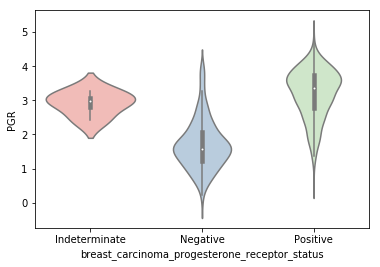

In [122]:
new_data = df_data[ df_data.data2.str.contains('^\[.*\]$',na=True,regex=True) == False ]
new_data.rename(columns={ "data1": gene_name , "data2": clinical_feature }, inplace=True)
        
sns.violinplot( x=new_data[clinical_feature], y=new_data[gene_name], palette="Pastel1")

##  BigQuery to Compute statistical association 

The Kruskal-Wallis score (H) is computed by using the following equation: 

$$H = \frac{(N-1)\sum_{i=1}^{g} n_i (\bar{r_{i}} -\bar{r} )^2 }{ \sum_{i=1}^{g} \sum_{j=1}^{n_i} (r_{ij}-\bar{r})^2   }$$
where

- $n_i$ is the number of observations in category $i$
- $r_{ij}$ is the rank (among all participants) of the gene expression of participant $j$ that belongs to category $i$
- $N$ is the total number of participants considered in the test
- $\bar{r_i}$ is the averange rank of gene expression values for particpants in category $i$
- $\bar{r}$ is the average of all $r_{ij}$

To avoid reading that table multiple times, we rearranged the equations above as :

$$H = (N-1)\frac{ \sum_{i=1}^{g}S_i^2/n_i - (\sum_{i=1}^{g}S_i)^2 / N }{ \sum_{i=1}^{g}Q_i - (\sum_{i=1}^{g}S_i)^2 / N }$$

Where $S_i = \sum_{j=1}^{n_i}r_{ij}$ and  $Q_i = \sum_{j=1}^{n_i}r_{ij}^2$

The following query string computes $S_i$ and $Q_i$:

In [123]:
summ_table = """
summ_table  AS (
SELECT 
   COUNT( ParticipantBarcode) AS ni,
   SUM( rnkdata ) AS Si,
   SUM( rnkdata * rnkdata ) AS Qi,
   data2
FROM (    
   SELECT 
      (RANK() OVER (ORDER BY data1 ASC)) + (COUNT(*) OVER ( PARTITION BY CAST(data1 as STRING)) - 1)/2.0 AS rnkdata,
      data2, ParticipantBarcode
   FROM
      table_data 
   WHERE data2 IN ( SELECT data2 from table_data GROUP BY data2 HAVING count(data2)>{0} )   
)
GROUP BY
   data2
)
""".format( str(MinSampleSize) )

The query above ingnores the categories that have a number of participants smaller or equal than 'MinSampleSize'. Moreover, the gene expression is ranked, assigning **average** of ranks to the similar values( https://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.stats.rankdata.html). Finally, The Kruskall-Wallis score ($H$) is computed by the following BigQuery string. 

In [124]:
query_hscore = """
SELECT 
    Ngroups,
    N as Nsamples,        
    (N-1)*( sumSi2overni - (sumSi *sumSi)/N ) / (  sumQi  - (sumSi *sumSi)/N )    AS  Hscore 
FROM (
  SELECT 
      SUM( ni ) As N, 
      SUM( Si ) AS sumSi,
      SUM( Qi ) AS sumQi,
      SUM( Si * Si  / ni ) AS sumSi2overni,
      COUNT ( data2 ) AS Ngroups    
  FROM  summ_table
  )
WHERE 
   Ngroups > 1
ORDER BY Hscore DESC
"""

sql = ( sql_data + ',\n' + summ_table + query_hscore )
df_hscore = regulome.runQuery ( bqclient, sql, [] , dryRun=False )
df_hscore


 in runQuery ... 
    the results for this query were previously cached 


,Ngroups,Nsamples,Hscore
0,2,1030,473.928233


To test our implementation we can use the 'kruskalwallis' function available in python:

In [125]:
CategoryData = []
CategoryNames = [] 

for name, group in new_data.groupby( clinical_feature ) :
    data =  group[ gene_name ].values 
       
    if ( len( data ) > MinSampleSize ) :
   
         CategoryData.append( data )
         CategoryNames.append( name )
                
if len( CategoryData ) > 1 :
    print( mstats.kruskalwallis( *[ mydata for mydata in CategoryData   ] ) )
            



KruskalResult(statistic=473.92823340882796, pvalue=4.476760792858192e-105)
